# Back to the Reddit dataset for all traits
with models trained by GPT-3.5 generated dataset <br>
and similarity threshold == 0.95 <br>
In this notebook we'll analyze our Reddit-dataset and predict the probability for each personality trait for every musical genre. <br>
Those predictions will be followed by statistical tests

## (1) Filter out short texts

To effectively use the model, we need to use only long-enough texts. <br>
We set the threshold as the average length of texts used to train the model, which is **40** tokens.


### 1.1 AVG Length of posts per community


In [1]:
import os
import json
import statistics

directory = "./data/detailed_filtered_data"
threshold = 40

print(
    "[ Median | AVG ] number of posts left per user after filtering all posts shorter than 40 tokens: "
)
for root, dirs, files in os.walk(directory):
    for folder in dirs:
        counter_in_genre = []
        folder_path = os.path.join(root, folder)
        for file in os.listdir(folder_path):
            if file.endswith(".json"):
                file_path = os.path.join(folder_path, file)
                with open(file_path, "r") as json_file:
                    data = json.load(json_file)
                    counter = 0
                    for vector_file_name in data.keys():
                        for sub in data.get(vector_file_name, {}).get("submissions"):
                            if len(sub.get("title", "").split()) >= threshold:
                                counter += 1
                            if len(sub.get("body", "").split()) >= threshold:
                                counter += 1
                        for comment in data.get(vector_file_name, {}).get("comments"):
                            if len(comment.get("body", "").split()) >= threshold:
                                counter += 1
                    counter_in_genre.append(counter)
        if counter_in_genre:
            print(
                folder,
                "[",
                statistics.median(counter_in_genre),
                "|",
                statistics.mean(counter_in_genre),
                "]",
            )

[ Median | AVG ] number of posts left per user after filtering all posts shorter than 40 tokens: 
indieheads [ 35.0 | 84.467 ]
hiphopheads [ 82.0 | 121.983 ]
Metal [ 53.5 | 103.118 ]
electronicmusic [ 43.0 | 97.761 ]
classicalmusic [ 117.0 | 172.252 ]


### 1.2 Process the data as a DataFrame
 & Filter out short texts


In [2]:
import pandas as pd
import os
import json
from tqdm import tqdm

df = pd.DataFrame(columns=["community", "user_name", "user_texts", "#_of_long_texts"])


def process_files(community, df):
    threshold = 40
    directory = f"./data/detailed_filtered_data/texts/{community}"
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".json"):
            user_texts = []
            with open(os.path.join(directory, filename), "r") as f:
                data = json.load(f)
                for key in data:
                    for submission in data[key].get("submissions", []):
                        title = submission.get("title", "")
                        body = submission.get("body", "")
                        if len(title.split()) >= threshold:
                            user_texts.append(title)
                        if len(body.split()) >= threshold:
                            user_texts.append(body)
                    for submission in data[key].get("comments", []):
                        body = submission.get("body", "")
                        if len(body.split()) >= threshold:
                            user_texts.append(body)
            if len(user_texts) == 0:
                continue
            user_name = filename.split(".json")[0]
            new_row = pd.DataFrame(
                {
                    "community": community,
                    "user_name": [user_name],
                    "user_texts": [user_texts],
                    "#_of_long_texts": [len(user_texts)],
                }
            )
            df = pd.concat([df, new_row], ignore_index=True)
    return df


communities = [
    "classicalmusic",
    "electronicmusic",
    "hiphopheads",
    "indieheads",
    "Metal",
]

for vector_file_name in communities:
    df = pd.concat([df, process_files(vector_file_name, df)])
print("Done processing texts :)")

100%|██████████| 1000/1000 [00:01<00:00, 878.96it/s]

Done processing texts :)


### 1.3 De-Duplication


In [3]:
def deduplicate_texts(df):
    exploded_df = df.explode("user_texts")
    exploded_df = exploded_df.drop_duplicates(subset="user_texts")
    return exploded_df


df = deduplicate_texts(df)
print("After dedeuplication there are", format(len(df), ","), "unique texts in total")

After dedeuplication there are 575,816 unique texts in total


In [4]:
classicalmusic_df = df[df["community"] == "classicalmusic"]
electronicmusic_df = df[df["community"] == "electronicmusic"]
hiphopheads_df = df[df["community"] == "hiphopheads"]
indieheads_df = df[df["community"] == "indieheads"]
metal_df = df[df["community"] == "Metal"]

communities_dfs = [
    classicalmusic_df,
    electronicmusic_df,
    hiphopheads_df,
    indieheads_df,
    metal_df,
]

print(
    "Number of texts left after deduplication per community:",
    "\nClassicalmusic:",
    format(len(classicalmusic_df), ","),
    "\nElectronicmusic:",
    format(len(electronicmusic_df), ","),
    "\nHiphopheads:",
    format(len(hiphopheads_df), ","),
    "\nIndieheads:",
    format(len(indieheads_df), ","),
    "\nMetal:",
    format(len(metal_df), ","),
)

Number of texts left after deduplication per community: 
Classicalmusic: 170,251 
Electronicmusic: 97,063 
Hiphopheads: 121,538 
Indieheads: 84,314 
Metal: 102,650


In [5]:
classicalmusic_counts = classicalmusic_df["user_name"].value_counts()
electronicmusic_counts = electronicmusic_df["user_name"].value_counts()
hiphopheads_counts = hiphopheads_df["user_name"].value_counts()
indieheads_counts = indieheads_df["user_name"].value_counts()
metal_counts = metal_df["user_name"].value_counts()


print("Median and Mean of texts-count per user in each community after deduplication:")
print(
    "classicalmusic: Median =",
    classicalmusic_counts.median(),
    " | Mean =",
    round(classicalmusic_counts.mean(), 2),
)
print(
    "electronicmusic: Median =",
    electronicmusic_counts.median(),
    " | Mean =",
    round(electronicmusic_counts.mean(), 2),
)
print(
    "hiphopheads: Median =",
    hiphopheads_counts.median(),
    " | Mean =",
    round(hiphopheads_counts.mean(), 2),
)
print(
    "indieheads: Median =",
    indieheads_counts.median(),
    " | Mean =",
    round(indieheads_counts.mean(), 2),
)
print(
    "metal: Median =", metal_counts.median(), " | Mean =", round(metal_counts.mean(), 2)
)

Median and Mean of texts-count per user in each community after deduplication:
classicalmusic: Median = 118.5  | Mean = 173.37
electronicmusic: Median = 60.5  | Mean = 109.55
hiphopheads: Median = 83.0  | Mean = 122.39
indieheads: Median = 52.0  | Mean = 96.8
metal: Median = 58.0  | Mean = 107.94


## (2) Vectorize all Redditors texts


### 2.1 Vectorize


#### 2.1.1 Vectorization method

In [6]:
from sentence_transformers import SentenceTransformer
from typing import List, Union
from torch import Tensor
from numpy import ndarray


def vectorize_text(
    text, model: SentenceTransformer, batch_size=12, show_progress_bar=False
) -> Union[List[Tensor], ndarray, Tensor]:
    return model.encode(
        text, show_progress_bar=show_progress_bar, batch_size=batch_size
    )

#### 2.1.2 Vectorize & persist or reload


In [9]:
import h5py
import numpy as np
from tqdm import tqdm
import os

model = SentenceTransformer("intfloat/e5-large-v2")


def vectorize_or_load_community_data(community_name: str, df: pd.DataFrame):
    file_path = f"data/detailed_filtered_data/vectors/{community_name}.h5"
    if os.path.exists(file_path):
        print(f"Loading vectors for {community_name} from file")
        with h5py.File(file_path, "r") as f:
            dataset = f["vectors"]
            df["vector"] = dataset[:].tolist()
    else:
        print(f"Vectorizing texts for {community_name}...")
        compression = "lzf"
        estimated_rows = len(df)

        with h5py.File(file_path, "a") as f:
            if "vectors" not in f:
                dataset = f.create_dataset(
                    "vectors",
                    (estimated_rows, model.get_sentence_embedding_dimension()),
                    dtype=np.float32,
                    compression=compression,
                )
                print("Dataset shape:", dataset.shape)
            else:
                dataset = f["vectors"]

            i = 0
            progress_bar = tqdm(total=estimated_rows, desc="Vectorizing texts")
            for _, row in df.iterrows():
                vector = vectorize_text(row["user_texts"], model)
                dataset[i] = vector
                i += 1
                progress_bar.update(1)
            progress_bar.close()



In [10]:
community_names = ["classical", "electronic", "hiphopheads", "indieheads", "metal"]
for community_name, df in zip(community_names, communities_dfs):
    vectorize_or_load_community_data(community_name, df)
df = pd.concat(communities_dfs, ignore_index=True)

Loading vectors for classical from file
Loading vectors for electronic from file
Loading vectors for hiphopheads from file
Loading vectors for indieheads from file
Loading vectors for metal from file


### 2.4 Show Sample


In [12]:
df.head()

,community,user_name,user_texts,#_of_long_texts,vector
0,classicalmusic,Radaxen,I remember doing this with WC3 Dota 1 Lifestea...,339,"[-0.0013457498280331492, -0.06375082582235336,..."
1,classicalmusic,Radaxen,Why not? Though there's no AD in League. I ki...,339,"[0.018474051728844643, -0.01666010357439518, 0..."
2,classicalmusic,Radaxen,"Haha I was kind of joking. That aside, why mos...",339,"[-0.008903076872229576, -0.05069487541913986, ..."
3,classicalmusic,Radaxen,"Mana is often a less limiting factor, unless y...",339,"[0.04738666117191315, -0.053208597004413605, 0..."
4,classicalmusic,Radaxen,"It's first pick worthy, but late in first phas...",339,"[0.007831799797713757, -0.0637780949473381, 0...."


## (3) Back to Logistic regression


### 3.1 Load the traits models

Since the models trained by GPT-generated-dataset performed best against the Bard's unseen data, We chose them to move on with


In [13]:
import pickle
from sklearn.linear_model import LogisticRegression

traits_and_models = {"opn": None, "ext": None}

for trait in traits_and_models.keys():
    with open(f"models/step-10/gpt_{trait}.pkl", "rb") as f:
        traits_and_models[trait] = pickle.load(f)

### 3.2 Predict-Probablily

Use the model to Predict-Probablily for every user texts to be in high vs low trait classes, and then <br>
Calculate the average predicted probability for every user's trait classes (high vs low trait (out of the Big Five))


In [14]:
import numpy as np


def predict_trait_probab(trait: str, df: pd.DataFrame, model: LogisticRegression):
    df[f"{trait}_proba"] = df["vector"].apply(
        lambda x: model.predict_proba(np.array(x).reshape(1, -1))
    )
    average_trait_proba = df.groupby("user_name")[f"{trait}_proba"].apply(
        lambda x: x.apply(lambda y: y[0][0]).mean()
    )
    df[f"proba_for_high_{trait}"] = df["user_name"].map(average_trait_proba)
    df = df.drop(columns=[f"{trait}_proba"])
    return df

In [15]:
for trait, model in traits_and_models.items():
    df = predict_trait_probab(trait, df, model)

df = df.drop_duplicates(subset="user_name")
df = df.drop(columns=["user_texts", "vector"])
df.groupby("community").head(2)

,community,user_name,#_of_long_texts,proba_for_high_opn,proba_for_high_ext
0,classicalmusic,Radaxen,339,0.423429,0.471958
339,classicalmusic,diskoalafied,52,0.441590,0.413815
170251,electronicmusic,headphase,305,0.411137,0.525291
170553,electronicmusic,MarvAlbertNBAjam,146,0.438118,0.579137
267314,hiphopheads,thanks_bruh,50,0.422216,0.482296
267364,hiphopheads,acasovoycayendo,145,0.420888,0.537052
388852,indieheads,simco1974,1,0.511495,0.443740
388853,indieheads,GeorgeTaylorG,12,0.445206,0.483947
473166,Metal,sam1oq,309,0.404776,0.463136
473475,Metal,feckineejit,111,0.400082,0.513688


## (4) Analyze predictions

AVG and Median probability for every personality trait Per Genre, <br>
followed by bar chart and box plot (for each trait)


In [16]:
import matplotlib.pyplot as plt
import numpy as np


def plot_bars_for_high_trait_probability(means: list[float], medians: list[float], trait: str):
    labels = ["Metal", "Classical", "Electronic", "HipHop", "Indie"]
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width / 2, means, width, label="Mean")
    rects2 = ax.bar(x + width / 2, medians, width, label="Median")

    ax.set_ylabel("Scores")
    ax.set_title(f"Probability For High {trait}")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                "{:.3f}".format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height / 2),
                xytext=(0, 0),  # no offset
                textcoords="offset points",
                ha="center",
                va="center",
                rotation=90,
            )
    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    plt.show()

In [17]:
import pandas as pd
import matplotlib.pyplot as plt


def draw_proba_box_plot(class_name: str):
    plt.figure(figsize=(12, 6))

    bp = plt.boxplot(
        [df[df["community"] == c][class_name] for c in df["community"].unique()],
        notch=True,
        vert=False,
        labels=df["community"].unique(),
        patch_artist=True,
    )

    for box, color in zip(
        bp["boxes"], ["skyblue", "lightgreen", "orange", "pink", "purple"]
    ):
        box.set_facecolor(color)

    plt.xlabel(class_name)
    plt.ylabel("Community")
    plt.title(f"Box Plots of {class_name} by Community by: `intfloat/e5-large-v2`")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

opn statistics:
Mean values:
community
Metal              0.437629
classicalmusic     0.444930
electronicmusic    0.443111
hiphopheads        0.418848
indieheads         0.439702
Name: proba_for_high_opn, dtype: float64

Median values:
community
Metal              0.433077
classicalmusic     0.439991
electronicmusic    0.435327
hiphopheads        0.414559
indieheads         0.434058
Name: proba_for_high_opn, dtype: float64


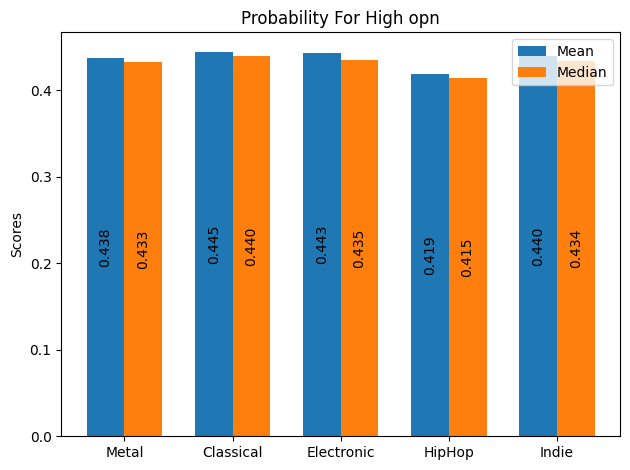

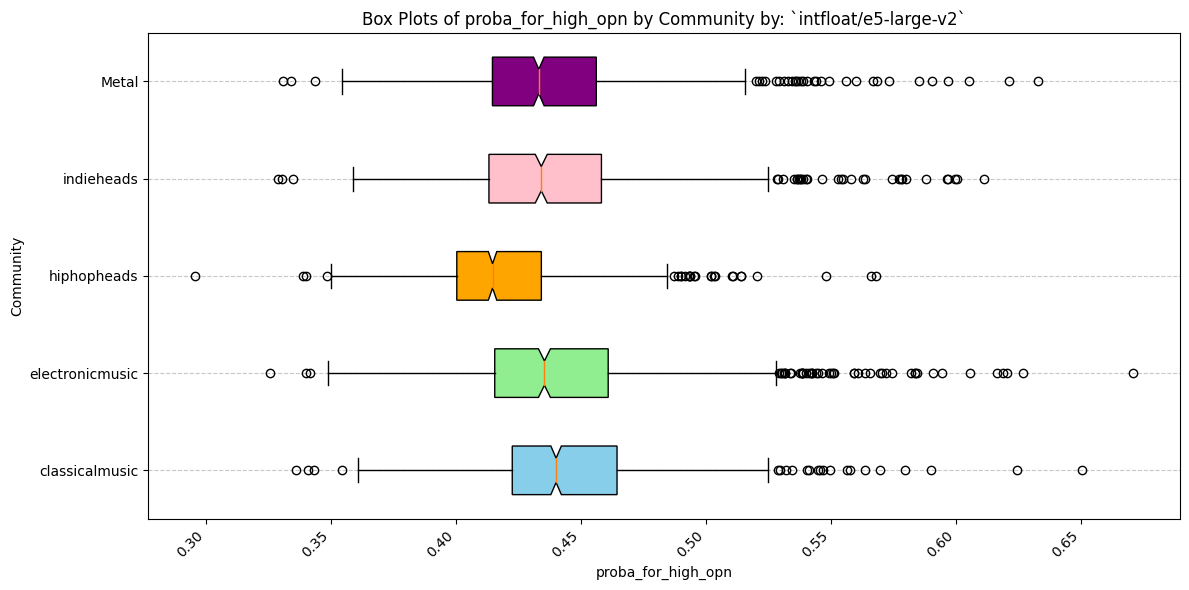

ext statistics:
Mean values:
community
Metal              0.508919
classicalmusic     0.480231
electronicmusic    0.524614
hiphopheads        0.522556
indieheads         0.511897
Name: proba_for_high_ext, dtype: float64

Median values:
community
Metal              0.510583
classicalmusic     0.480781
electronicmusic    0.523318
hiphopheads        0.523584
indieheads         0.513194
Name: proba_for_high_ext, dtype: float64


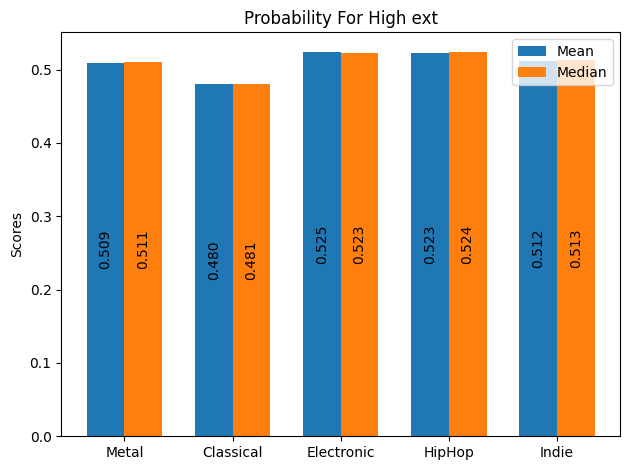

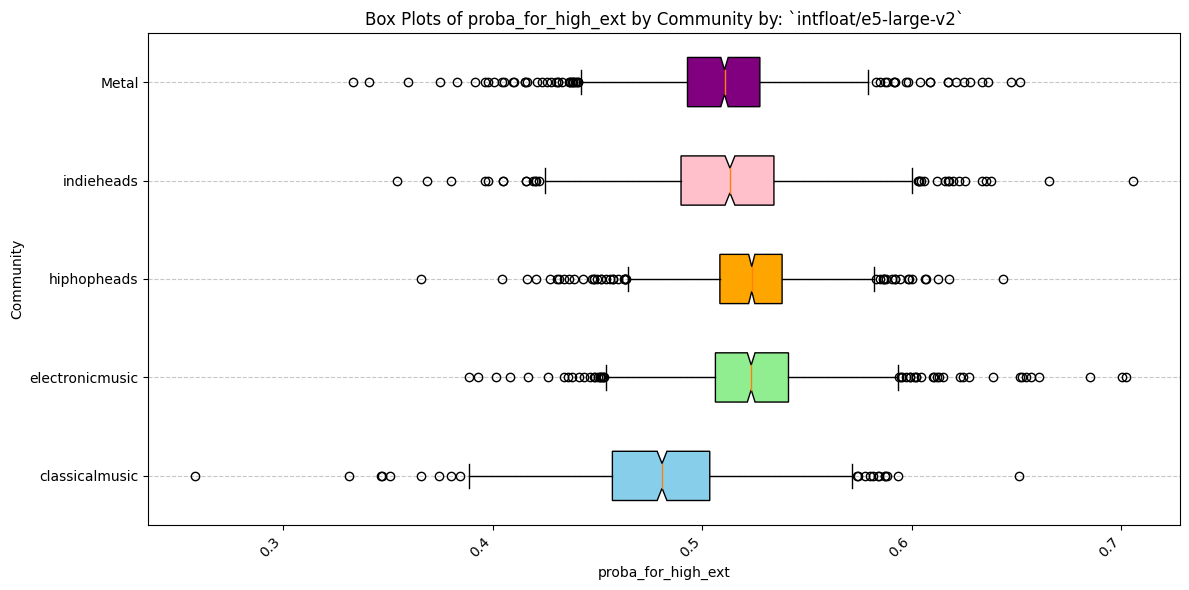

In [18]:
for trait in traits_and_models.keys():
    print(f"{trait} statistics:")
    column_name = f"proba_for_high_{trait}"
    mean_values = df.groupby("community")[column_name].mean()
    median_values = df.groupby("community")[column_name].median()
    print("Mean values:")
    print(mean_values)
    print("\nMedian values:")
    print(median_values)
    plot_bars_for_high_trait_probability(mean_values, median_values, trait)
    draw_proba_box_plot(column_name)

In [19]:
print("Example of the dataframe we have now:")
df.head()

Example of the dataframe we have now:


,community,user_name,#_of_long_texts,proba_for_high_opn,proba_for_high_ext
0,classicalmusic,Radaxen,339,0.423429,0.471958
339,classicalmusic,diskoalafied,52,0.441590,0.413815
391,classicalmusic,MantisTobogan-MD,176,0.501400,0.488187
566,classicalmusic,Sommiel,43,0.446392,0.505100
609,classicalmusic,Dangerous_Number_642,20,0.494970,0.464831


## (5) Statistical Tests


In [20]:
# Preps
group_names = ["classical", "electronic", "hiphop", "indie", "metal"]
classicalmusic_df = df[df["community"] == "classicalmusic"]
electronicmusic_df = df[df["community"] == "electronicmusic"]
hiphopheads_df = df[df["community"] == "hiphopheads"]
indieheads_df = df[df["community"] == "indieheads"]
metal_df = df[df["community"] == "Metal"]

### 5.1 ANOVA

Now that we have ~1K of probability-for-openness score per musical genre community, <br>
we want to understand how significant are the differences between the groups' scores. To do so, we will use the ANOVA test. <br>
ANOVA compares the variance between-groups means to the variance within-groups. If the variance between-groups is larger than the within-groups, it suggests that there are differences in means among the groups.


In [21]:
import scipy.stats as stats

for trait in traits_and_models.keys():
    column_name = f"proba_for_high_{trait}"
    data = [
        classicalmusic_df[column_name],
        electronicmusic_df[column_name],
        hiphopheads_df[column_name],
        indieheads_df[column_name],
        metal_df[column_name],
    ]
    fvalue, pvalue = stats.f_oneway(*data)
    print(f"[{trait}] | F-value:", fvalue)
    print(
        f"[{trait}] | P-value: {pvalue} which is {format(pvalue, '.10f')} when taking only the 10 first digits after the decimal point"
    )

[opn] | F-value: 82.7337820365974
[opn] | P-value: 5.730209044728592e-68 which is 0.0000000000 when taking only the 10 first digits after the decimal point
[ext] | F-value: 258.37967195156705
[ext] | P-value: 7.185767178763123e-201 which is 0.0000000000 when taking only the 10 first digits after the decimal point


### 5.2 T-Test & Cohen's D Test

**T-Test**: The T-Test is a statistical hypothesis test where the test statistic follows a score's t-distribution under the null hypothesis. It is used to determine whether there is a significant difference between the means of two groups. <br>

**Cohen's d**: Cohen's D is an effect size used to indicate the standardized difference between two means. It's often used in the analysis of t-tests and is considered a good measure of effect size for these tests. It's defined as the difference between two means divided by a standard deviation for the data.

_Note_: A D value of 0.2 is considered a 'small' effect size, 0.5 represents a 'medium' effect size and 0.8 a 'large' effect size. This is just a rule of thumb. The interpretation of d depends on the context.


In [24]:
from scipy import stats
import pingouin as pg
from tabulate import tabulate
from IPython.display import display, HTML


def calculate_cohens_d_and_t_test(data, group_names, second_part_title):
    results = []

    for i in range(len(data)):
        for j in range(i + 1, len(data)):
            t_stat, p_val = stats.ttest_ind(data[i], data[j])
            effect_size = pg.compute_effsize(data[i], data[j])

            # Append the results to the list just for nice tabular representation
            results.append(
                [
                    group_names[i],
                    group_names[j],
                    len(data[i]),
                    len(data[j]),
                    format(t_stat, ".10f"),
                    format(p_val, ".10f"),
                    format(effect_size, ".10f"),
                ]
            )

    table_headers = [
        "Genre 1",
        "Genre 2",
        "Genre 1 # Of Samples",
        "Genre 2 # Of Samples",
        "t-statistic",
        "p-value",
        "Effect Size",
    ]
    table = tabulate(results, headers=table_headers, tablefmt="fancy_grid")
    display(
        HTML(
            f"<h1 style='font-size: 50px;'>T & Cohen's D Tests | {second_part_title} </h1>"
        )
    )
    print(table)


def filter_data_and_print_stats(
    min_posts, column_name, title_suffix
):
    data = [
        classicalmusic_df[
            classicalmusic_df["#_of_long_texts"].astype(int) >= min_posts
        ][column_name],
        electronicmusic_df[
            electronicmusic_df["#_of_long_texts"].astype(int) >= min_posts
        ][column_name],
        hiphopheads_df[hiphopheads_df["#_of_long_texts"].astype(int) >= min_posts][
            column_name
        ],
        indieheads_df[indieheads_df["#_of_long_texts"].astype(int) >= min_posts][
            column_name
        ],
        metal_df[metal_df["#_of_long_texts"].astype(int) >= min_posts][column_name],
    ]
    title = f"{min_posts} =< Users' long posts {title_suffix}"
    calculate_cohens_d_and_t_test(data, group_names, title)

In [25]:
for trait in traits_and_models.keys():
    column_name = f"proba_for_high_{trait}"
    filter_data_and_print_stats(10, column_name, f"| {trait}")
    filter_data_and_print_stats(50, column_name, f"| {trait}")
    filter_data_and_print_stats(100, column_name, f"| {trait}")

╒════════════╤════════════╤════════════════════════╤════════════════════════╤═══════════════╤═════════════╤═══════════════╕
│ Genre 1    │ Genre 2    │   Genre 1 # Of Samples │   Genre 2 # Of Samples │   t-statistic │     p-value │   Effect Size │
╞════════════╪════════════╪════════════════════════╪════════════════════════╪═══════════════╪═════════════╪═══════════════╡
│ classical  │ electronic │                    870 │                    700 │      3.53578  │ 0.000418402 │    0.179525   │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼─────────────┼───────────────┤
│ classical  │ hiphop     │                    870 │                    912 │     19.8564   │ 0           │    0.941015   │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼─────────────┼───────────────┤
│ classical  │ indie      │                    870 │                    692 │      5.98211  │ 2.7e-09     │    0.304707   │
├───────

╒════════════╤════════════╤════════════════════════╤════════════════════════╤═══════════════╤═══════════╤═══════════════╕
│ Genre 1    │ Genre 2    │   Genre 1 # Of Samples │   Genre 2 # Of Samples │   t-statistic │   p-value │   Effect Size │
╞════════════╪════════════╪════════════════════════╪════════════════════════╪═══════════════╪═══════════╪═══════════════╡
│ classical  │ electronic │                    695 │                    478 │       5.12146 │ 3.542e-07 │     0.304324  │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼───────────┼───────────────┤
│ classical  │ hiphop     │                    695 │                    659 │      19.7651  │ 0         │     1.07467   │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼───────────┼───────────────┤
│ classical  │ indie      │                    695 │                    447 │       8.36556 │ 0         │     0.507203  │
├────────────┼──────────

╒════════════╤════════════╤════════════════════════╤════════════════════════╤═══════════════╤════════════╤═══════════════╕
│ Genre 1    │ Genre 2    │   Genre 1 # Of Samples │   Genre 2 # Of Samples │   t-statistic │    p-value │   Effect Size │
╞════════════╪════════════╪════════════════════════╪════════════════════════╪═══════════════╪════════════╪═══════════════╡
│ classical  │ electronic │                    549 │                    336 │       4.84816 │ 1.4721e-06 │     0.335809  │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼────────────┼───────────────┤
│ classical  │ hiphop     │                    549 │                    440 │      17.4158  │ 0          │     1.11437   │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼────────────┼───────────────┤
│ classical  │ indie      │                    549 │                    306 │       7.91942 │ 0          │     0.564975  │
├────────────┼──

╒════════════╤════════════╤════════════════════════╤════════════════════════╤═══════════════╤═══════════╤═══════════════╕
│ Genre 1    │ Genre 2    │   Genre 1 # Of Samples │   Genre 2 # Of Samples │   t-statistic │   p-value │   Effect Size │
╞════════════╪════════════╪════════════════════════╪════════════════════════╪═══════════════╪═══════════╪═══════════════╡
│ classical  │ electronic │                    870 │                    700 │    -29.0617   │  0        │    -1.47558   │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼───────────┼───────────────┤
│ classical  │ hiphop     │                    870 │                    912 │    -31.8243   │  0        │    -1.50819   │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼───────────┼───────────────┤
│ classical  │ indie      │                    870 │                    692 │    -19.3582   │  0        │    -0.986035  │
├────────────┼──────────

╒════════════╤════════════╤════════════════════════╤════════════════════════╤═══════════════╤═══════════╤═══════════════╕
│ Genre 1    │ Genre 2    │   Genre 1 # Of Samples │   Genre 2 # Of Samples │   t-statistic │   p-value │   Effect Size │
╞════════════╪════════════╪════════════════════════╪════════════════════════╪═══════════════╪═══════════╪═══════════════╡
│ classical  │ electronic │                    695 │                    478 │    -25.5225   │  0        │    -1.51658   │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼───────────┼───────────────┤
│ classical  │ hiphop     │                    695 │                    659 │    -28.288    │  0        │    -1.53807   │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼───────────┼───────────────┤
│ classical  │ indie      │                    695 │                    447 │    -16.9923   │  0        │    -1.03024   │
├────────────┼──────────

╒════════════╤════════════╤════════════════════════╤════════════════════════╤═══════════════╤═══════════╤═══════════════╕
│ Genre 1    │ Genre 2    │   Genre 1 # Of Samples │   Genre 2 # Of Samples │   t-statistic │   p-value │   Effect Size │
╞════════════╪════════════╪════════════════════════╪════════════════════════╪═══════════════╪═══════════╪═══════════════╡
│ classical  │ electronic │                    549 │                    336 │    -21.8877   │  0        │    -1.51606   │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼───────────┼───────────────┤
│ classical  │ hiphop     │                    549 │                    440 │    -23.6221   │  0        │    -1.51149   │
├────────────┼────────────┼────────────────────────┼────────────────────────┼───────────────┼───────────┼───────────────┤
│ classical  │ indie      │                    549 │                    306 │    -14.5501   │  0        │    -1.03801   │
├────────────┼──────────